In [ ]:
#| default_exp preprocessing

# PREPROCESSING

> API details.

In [1]:
#| export
import numpy as np
import h5py
import pandas as pd
from typing import Dict
from secrets import token_hex
from pathlib import Path
from scipy import stats
import pyfstat
import matplotlib.pyplot as plt
import os
import random
%matplotlib inline

22-11-06 23:04:38.908 pyfstat INFO    : Running PyFstat version 1.18.1
22-11-06 23:04:38.959 pyfstat.utils.importing INFO    : No $DISPLAY environment variable found, so importing matplotlib.pyplot with non-interactive 'Agg' backend.


In [2]:
#| export
def good_luck():
    return 'pass'

In [3]:
# | export
def read_file(filename):
    file_id = Path(filename).stem
    img = np.empty((2, 360, 128), dtype=np.float32)
    with h5py.File(filename, "r") as f:
        g = f[file_id]

        for ch, s in enumerate(["H1", "L1"]):
            a = g[s]["SFTs"][:, :4096] * 1e22  # Fourier coefficient complex64
            p = a.real**2 + a.imag**2  # power
            p /= np.mean(p)  # normalize
            p = np.mean(p.reshape(360, 128, 32), axis=2)  # compress 4096 -> 128
            img[ch] = p
    return img


def get_random_name(len_k=16):
    token = token_hex(len_k)
    return "h_" + token


def save_hdf(
    name: str,
    sft_h1: np.array,
    sft_l1: np.array,
    timestamps: Dict,
    frequency: np.array,
    meta_: dict,
):
    hf = h5py.File(f"{name}.h5", "w")
    g1 = hf.create_group(name.stem)
    h1 = g1.create_group("H1")
    h1.create_dataset("SFTs", data=sft_h1)
    h1.create_dataset("timestamps", data=timestamps["H1"])

    l1 = g1.create_group("L1")
    l1.create_dataset("SFTs", data=sft_l1)
    l1.create_dataset("timestamps", data=timestamps["L1"])

    hf.create_dataset("frequency_Hz", data=frequency)
    pd.DataFrame(meta_).to_csv(f"{name}.csv", index=False)


In [4]:
def generate_data(fn, save_folder, neg=False):
    # Generate signals with parameters drawn from a specific population

    # These parameters describe background noise and data format
    sq_h1 = np.random.uniform(1e-23, 5e-23)
    writer_kwargs = {
        "tstart": 1238166018,
        "duration": 86 * 86400,
        "detectors": "H1,L1",
        "sqrtSX": sq_h1,
        "Tsft": 1800,
        "SFTWindowType": "tukey",
        "SFTWindowBeta": random.choice([0.01, 0.001]),
        "Band": 0.2,
    }

    h_0 = lambda: writer_kwargs["sqrtSX"] / stats.uniform(1, 50).rvs()
    if neg:
        h_0 = 0
    signal_parameters_generator = pyfstat.AllSkyInjectionParametersGenerator(
        priors={
            "tref": writer_kwargs["tstart"],
            "F0": {"uniform": {"low": 50, "high": 500}},
            "F1": lambda: 10 ** stats.uniform(-12, 4).rvs(),
            "F2": 0,
            "h0": h_0,
            **pyfstat.injection_parameters.isotropic_amplitude_priors,
        },
    )

    # snrs = np.zeros(num_signals)
    # t_fns = list(Path('../data/test').glob('*.hdf5'))

    # Draw signal parameters.
    # Noise can be drawn by setting `params["h0"] = 0
    name = save_folder / f"hb_{fn}"
    params = signal_parameters_generator.draw()
    # same timestemps as in test data
    # writer_kwargs['timestamps'] = get_random_timesteps(random.choice(t_fns))
    writer_kwargs["outdir"] = f"PyFstat_example_data_ensemble/Signal_{fn}"
    writer_kwargs["label"] = f"Signal_{fn}"

    writer = pyfstat.Writer(**writer_kwargs, **params)
    writer.make_data()

    # SNR can be compute from a set of SFTs for a specific set
    # of parameters as follows:
    snr = pyfstat.SignalToNoiseRatio.from_sfts(
        F0=writer.F0, sftfilepath=writer.sftfilepath
    )
    squared_snr = snr.compute_snr2(
        Alpha=writer.Alpha,
        Delta=writer.Delta,
        psi=writer.psi,
        phi=writer.phi,
        h0=writer.h0,
        cosi=writer.cosi,
    )

    meta_ = {
        "alpha": [writer.Alpha],
        "daelta": [writer.Delta],
        "cosi": [writer.cosi],
        "psi": [writer.psi],
        "phi": [writer.phi],
        "h0": [writer.h0],
        "f0": [writer.F0],
        "f1": [writer.F1],
        "snr": [np.sqrt(squared_snr)],
    }
    # Data can be read as a numpy array using PyFstat
    frequency, timestamps, amplitudes = pyfstat.utils.get_sft_as_arrays(
        writer.sftfilepath
    )

    sft_h1 = amplitudes["H1"][1:, :]
    sft_l1 = amplitudes["L1"][1:, :]
    save_hdf(Path(name), sft_h1, sft_l1, timestamps, frequency, meta_)
    print(meta_)


In [5]:
generate_data('test_new', Path(''))

22-11-06 23:04:45.909 pyfstat.core INFO    : Creating Writer object...
22-11-06 23:04:45.911 pyfstat.utils.ephemeris INFO    : No /root/.pyfstat.conf file found. Will fall back to lal's automatic path resolution for files [earth00-40-DE405.dat.gz,sun00-40-DE405.dat.gz]. Alternatively, set 'earth_ephem' and 'sun_ephem' class options.
22-11-06 23:04:45.949 pyfstat.make_sfts INFO    : Generating SFTs with fmin=98.60517974712512, Band=0.2
22-11-06 23:04:45.949 pyfstat.make_sfts INFO    : Checking if we can re-use injection config file...
22-11-06 23:04:45.950 pyfstat.make_sfts INFO    : ...OK: config file PyFstat_example_data_ensemble/Signal_test_new/Signal_test_new.cff already exists.
22-11-06 23:04:45.951 pyfstat.make_sfts INFO    : ...file contents unmatched, updating PyFstat_example_data_ensemble/Signal_test_new/Signal_test_new.cff.
22-11-06 23:04:45.951 pyfstat.make_sfts INFO    : Writing config file: PyFstat_example_data_ensemble/Signal_test_new/Signal_test_new.cff
22-11-06 23:04:45.

In [6]:
img = read_file('/opt/slh/g2net/nbs/hb_test_new.h5')

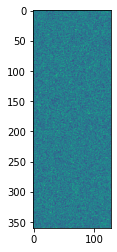

In [7]:
plt.imshow(img.mean(0))

In [ ]:
#name = Path("hb_test") #get_random_name()
#sft_h1 = np.random.rand(360, 4096)
#sft_l1 = np.random.rand(360, 4096)
#timestamps = dict({"H1": np.random.rand(400, ), 
#                   "L1": np.random.rand(400, )})
#frequency = np.random.rand(400,)
#meta_ = {"t": [23], 
#        "m": [23]}

In [ ]:
#|hide
#|eval: false
from nbdev.doclinks import nbdev_export
nbdev_export()